### Analysis of 40,000+ Oncology Studies from [ClinicalTrials.gov](www.clinicaltrials.gov)

#### Initial Exploratory Data Analysis

On August 18, 2016 I downloaded data on 43,692 clinical trials from the government registry [ClinicalTrials.gov](www.clinicaltrials.gov). I limited my search to all oncology-related trials in the database (there are over 200,000 trials in total). To cast as wide a net as possible, I included the following search terms in the "Conditions" field: cancer OR oncology OR neoplasm OR carcinoma OR leukemia OR lymphoma. After testing several combinations of terms, this set generated the largest number of search results.

**In bold below** are the questions I sought to answer on my first go-round with the data.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
% matplotlib inline
import seaborn as sns

In [3]:
# Read in data
trials = pd.read_csv('assets/study_fields.csv')

In [7]:
# View dimensions
trials.shape

(43962, 26)

In [10]:
# View column headers
trials.columns.values

array(['Rank', 'NCT Number', 'Title', 'Recruitment', 'Study Results',
       'Conditions', 'Interventions', 'Sponsor/Collaborators', 'Gender',
       'Age', 'Phases', 'Enrollment', 'Funded Bys', 'Study Types',
       'Study Designs', 'Other IDs', 'First Received', 'Start Date',
       'Completion Date', 'Last Updated', 'Last Verified',
       'Results First Received', 'Acronym', 'Primary Completion Date',
       'Outcome Measures', 'URL'], dtype=object)

## What's the distribution of cancer types in the data set?

##### For example, how many trials for cervical cancer are there?

In [11]:
# Search the "Conditions" column for cells that contain "cerv" for "cervical"
trials.Conditions.str.contains('cerv', case=False).value_counts()

False    43264
True       698
Name: Conditions, dtype: int64

##### Another example: kidney cancer is also called renal cell carcinoma. How many trials are there for either of these?

In [13]:
# Slice dataframe to get value counts for kidney cancer/renal cell carcinoma
((trials['Conditions'].str.contains('renal', case=False)) | 
          (trials['Conditions'].str.contains('kidney', case=False))).value_counts()

False    42827
True      1135
Name: Conditions, dtype: int64

##### Add a dummy column for each of the major cancer types

In [14]:
# List of cancer sites
cancer_sites = [('breast', 'Breast'), ('lung', 'Lung'), ('colo', 'Colorectal'), ('prostate', 'Prostate'),
                ('pancrea', 'Pancreatic'), ('thyroid', 'Thyroid'), ('ovar', 'Ovarian'), ('melanoma', 'Melanoma'),
               ('esoph', 'Esophageal'), ('myeloma', 'Multiple Myeloma'), ('lymphoma', 'Lymphomas'),
                ('leukemia', 'Leukemias'), ('uter', 'Uterine'), ('bladder', 'Bladder'), ('cerv', 'Cervical'),
               ('head and neck', 'Head and Neck'), ('liver', 'Liver'), ('testi', 'Testicular')]

In [15]:
# Add columns for cancer sites
for search_term, site in cancer_sites:
    trials[site] = trials.Conditions.str.contains(search_term, case=False)
    trials[site] = trials[site].map({True:1, False:0})

In [16]:
# List of cancer sites with multiple names
cancer_sites_mult_names = [(('brain', 'glio'), 'Brain'), (('kidney', 'renal'), 'Kidney'), (('stomach', 'gastric'), 'Gastric'),
                           (('bone', 'osteos'), 'Bone'), (('soft tissue', 'gastrointestinal stromal'), 'Soft-tissue')]

In [17]:
# Add additional columns for cancer sites with multiple search terms
for search_terms, site in cancer_sites_mult_names:
    trials[site] = ((trials.Conditions.str.contains(search_terms[0], case=False)) | 
                     (trials.Conditions.str.contains(search_terms[1], case=False)))
    trials[site] = trials[site].map({True:1, False:0})

##### Graph the data with plotly

In [26]:
x = trials.iloc[:, -23:].sum().sort_values(ascending=False).index.values
y = trials.iloc[:, -23:].sum().sort_values(ascending=False).values


array([5013, 3578, 3042, 2726, 2707, 2207, 1677, 1542, 1515, 1378, 1249,
       1135, 1046,  985,  855,  793,  698,  588,  585,  437,  425,  393,
        349])

In [27]:
import plotly.plotly as py
import plotly.graph_objs as go

In [35]:
data = [
    go.Bar(
    x = trials.iloc[:, -23:].sum().sort_values(ascending=True).values,
    y = trials.iloc[:, -23:].sum().sort_values(ascending=True).index.values,
    orientation='h')
]

layout = go.Layout(margin=dict(
    l=120, r=30, b=60, t=60))

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='cancer_counts_hbar')

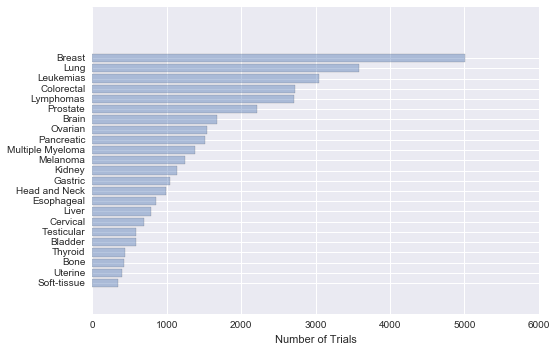

In [22]:
# Number of cancer sites - for number of bars on plot
num_cancer_sites = np.arange(len(cancer_sites) + len(cancer_sites_mult_names))

# Trial totals - for length of bars
trial_totals_by_site = trials.iloc[:, -23:].sum().sort_values(ascending=False).values

# Names of cancer sites - for bar labels
cancer_sites_high_to_low = trials.iloc[:, -23:].sum().sort_values(ascending=False).index

# Create horizontal bar
plt.barh(num_cancer_sites, trial_totals_by_site, align='center', alpha=0.4)

# Create yticks
plt.yticks(num_cancer_sites, cancer_sites_high_to_low)

# Create xlabel
plt.xlabel('Number of Trials')

# Invert graph
plt.gca().invert_yaxis()

#### Other variables

In [15]:
# split pipe delimited sponsor names into a list in each cell
s = trials['Sponsor/Collaborators'].str.split('|')

In [16]:
# The lead sponsor is the first one listed - generate new list with only lead sponsor
lead_sponsors = [row[0] for row in s]

In [17]:
# Turn lead_sponsors list to a pandas series
lead_sponsors_series = pd.Series(lead_sponsors)

In [18]:
# Get value counts
lead_sponsors_series.value_counts().sort_values(ascending=False)[:50]

M.D. Anderson Cancer Center                                 1387
National Cancer Institute (NCI)                             1263
Memorial Sloan Kettering Cancer Center                       854
Hoffmann-La Roche                                            605
Novartis Pharmaceuticals                                     478
Mayo Clinic                                                  403
AstraZeneca                                                  400
Pfizer                                                       320
Dana-Farber Cancer Institute                                 300
GlaxoSmithKline                                              299
Massachusetts General Hospital                               299
Washington University School of Medicine                     292
Eli Lilly and Company                                        289
Bristol-Myers Squibb                                         284
University Health Network, Toronto                           273
Sidney Kimmel Comprehensi

#### Trial enrollment

In [19]:
trials.columns

Index([u'Rank', u'NCT Number', u'Title', u'Recruitment', u'Study Results',
       u'Conditions', u'Interventions', u'Sponsor/Collaborators', u'Gender',
       u'Age', u'Phases', u'Enrollment', u'Funded Bys', u'Study Types',
       u'Study Designs', u'Other IDs', u'First Received', u'Start Date',
       u'Completion Date', u'Last Updated', u'Last Verified',
       u'Results First Received', u'Acronym', u'Primary Completion Date',
       u'Outcome Measures', u'URL', u'Breast', u'Lung', u'Colorectal',
       u'Prostate', u'Pancreatic', u'Thyroid', u'Ovarian', u'Melanoma',
       u'Esophageal', u'Multiple Myeloma', u'Lymphomas', u'Leukemias',
       u'Uterine', u'Bladder', u'Cervical', u'Head and Neck', u'Liver',
       u'Testicular', u'Brain', u'Kidney', u'Gastric', u'Bone',
       u'Soft-tissue'],
      dtype='object')

In [20]:
# Convert to numeric
trials['Enrollment'] = pd.to_numeric(trials.Enrollment, errors='coerce')

In [21]:
trials.Enrollment.isnull().sum()

419

In [22]:
# Create a new series without the nans
without_nulls_enrollment = trials[['NCT Number', 'Enrollment', 'Study Types', 'Recruitment']].dropna()

In [23]:
# alright, clear outlier
without_nulls_enrollment['Enrollment'].max()

99999999.0

In [24]:
# View all the trials with enrollment of greater than 10k
without_nulls_enrollment[without_nulls_enrollment['Enrollment'] > 10000].head()

,NCT Number,Enrollment,Study Types,Recruitment
6,NCT01178736,36000.0,Observational,Not yet recruiting
27,NCT00757614,14000.0,Observational,Recruiting
77,NCT01236053,2323608.0,Observational,Completed
369,NCT00765193,14381.0,Interventional,Completed
395,NCT01137643,15000.0,Observational,Recruiting


In [25]:
# How many interventional trials with greater than 10k participants?
without_nulls_enrollment[without_nulls_enrollment['Enrollment'] > 100000]['Study Types'].value_counts()
# There are still a good number of trials with over 100k participants, so not comfortable removing outliers
# I would need to remove outliers if I wanted to do a swarm plot

Observational     37
Interventional     9
Name: Study Types, dtype: int64

In [33]:
# View enrollment stats based on each recruitment category
without_nulls_enrollment.groupby('Recruitment').agg([np.mean, np.count_nonzero,])

Enrollment              
                                 mean count_nonzero
Recruitment                                        
Active, not recruiting    1011.809568        6417.0
Completed                 3356.210996       14349.0
Enrolling by invitation   7005.757366         577.0
Not yet recruiting         474.389142        2634.0
Recruiting               21934.732221       14861.0
Suspended                  144.589172         314.0
Terminated                  63.077882        3201.0

In [34]:
# Remove the trials with recruitment status 'withdrawn
without_nulls_enrollment = without_nulls_enrollment.loc[without_nulls_enrollment['Recruitment'] != 'Withdrawn']

In [35]:
# Bin data
bins = [-1, 50, 200, 400, 1000, 5000, 1000000000]
group_names = ['0-50', '51-200', '201-400', '401-1000', '1001-5000', '>5000']
categories = pd.cut(without_nulls_enrollment['Enrollment'], bins, labels=group_names)

In [36]:
# Add categories as column in dataframe
without_nulls_enrollment['Category'] = categories

In [37]:
# View value counts
without_nulls_enrollment['Category'].value_counts()

0-50         18791
51-200       14690
201-400       3854
401-1000      3065
1001-5000     1469
>5000          497
dtype: int64

In [38]:
# View value counts for Interventional vs. observational
without_nulls_enrollment['Study Types'].value_counts()

Interventional    34439
Observational      7927
Name: Study Types, dtype: int64

In [39]:
# Group by category
groupby_enrollment = without_nulls_enrollment.groupby(['Category', 'Study Types']).count()
groupby_enrollment

NCT Number  Enrollment  Recruitment
Category  Study Types                                        
0-50      Interventional       16724       16724        16724
          Observational         2067        2067         2067
51-200    Interventional       12010       12010        12010
          Observational         2680        2680         2680
201-400   Interventional        2783        2783         2783
          Observational         1071        1071         1071
401-1000  Interventional        2016        2016         2016
          Observational         1049        1049         1049
1001-5000 Interventional         716         716          716
          Observational          753         753          753
>5000     Interventional         190         190          190
          Observational          307         307          307

In [40]:
without_nulls_enrollment['Study Types'].value_counts()

Interventional    34439
Observational      7927
Name: Study Types, dtype: int64

In [41]:
# Dataframe with slice of just interventionals
interventional = without_nulls_enrollment.loc[without_nulls_enrollment['Study Types'] == 'Interventional']

# Groupby 
intervent_enrollment_counts = interventional.groupby('Category').count()['Enrollment']

In [42]:
# Dataframe with slice of just observationals
observational = without_nulls_enrollment.loc[without_nulls_enrollment['Study Types'] == 'Observational']

# Groupby
observ_enrollment_counts = observational.groupby('Category').count()['Enrollment']

In [50]:
for i in intervent_enrollment_counts.values:
    print i

16724
12010
2783
2016
716
190


In [217]:
# try using plotly to graph this
import plotly.plotly as py
import plotly.graph_objs as go
py.sign_in('mshea88', '04kbbynyqj')

In [218]:
X = list(without_nulls_enrollment['Category'].unique())
y1 = intervent_enrollment_counts
y2 = observ_enrollment_counts

df = pd.DataFrame({'Enrollment':X, 'Interventional':y1, 'Observational':y2})

In [219]:
data = [go.Bar(x=df['Enrollment'], y=df['Interventional']), 
       go.Bar(x=df['Enrollment'], y=df['Observational'])]

In [221]:
layout = go.Layout(barmode='stack', title='Trial Enrollment')
fig = go.Figure(data=data, layout=layout)
url = py.plot(data, filename='enrollment-by-recruitment-type')

In [115]:
# stipplot unfortunately doesn't work with outliers
# sns.stripplot(x="Study Types", y="Enrollment", data=without_nulls_enrollment, jitter=True)

#### Age

In [29]:
import re

In [30]:
trials.ix[11, 'Age']

'Child, Adult, Senior'

In [33]:
# left off trying to split age groups up, got tripped up by adult and adult, senior. maybe
# consider putting all adults and adult, seniors in a list then parsing out adult, seniors

adult_senior = 0
adult = 0
child = 0
senior = 0
child_adult_senior = 0
child_adult = 0

for row in trials.Age:
    if '(Adult, Senior)' in row:
        adult_senior += 1
    elif '(Adult)' in row:
        adult += 1
    elif 'Child, Adult, Senior' in row:
        child_adult_senior += 1
    elif 'Child, Adult' in row:
        child_adult += 1
    elif "(Child)" in row:
        child += 1
    elif "(Senior)" in row:
        senior += 1

In [34]:
print "Senior %d" % senior
print "Adult/Senior %d" % adult_senior
print "Adult %d" % adult
print "Child/Adult/Senior %d" % child_adult_senior
print "Child/Adult %d" % child_adult
print "Child %d" % child

Senior 225
Adult/Senior 35047
Adult 2792
Child/Adult/Senior 3594
Child/Adult 1804
Child 500


#### Gender

In [54]:
trials.Gender.value_counts()

Both      34809
Female     6567
Male       2543
null         43
Name: Gender, dtype: int64

### Convert date columns to proper format
First Recieved, Start Date, Completion Date, Results First Received all need to be converted to datetime

In [16]:
# Convert first received to datetime
trials['First Received'] = pd.to_datetime(trials['First Received'], infer_datetime_format = True)
# trials['Start Date'] = pd.to_datetime(trials['Start Date'], errors='coerce')
# trials['Completion Date'] = pd.to_datetime(trials['Completion Date'], errors='coerce')
# trials['Results First Received'] = pd.to_datetime(trials['Results First Received'], errors='coerce')
# trials['Primary Completion Date'] = pd.to_datetime(trials['Primary Completion Date'], errors='coerce')

### Trends over time visualizations
#### View phase of trials over time

In [17]:
# Create new df object with date of First Received as index
over_time = trials[['Phases']].set_index(trials['First Received'])

# Drop NaNs (there are a considerable number)
over_time.dropna(axis=0, inplace=True)

# Limit to before 2016
over_time = over_time[over_time.index < '20160101']

# Create columns for each phase
over_time_dummies = pd.get_dummies(over_time, prefix='', prefix_sep='')



# # Plot phases over time
# from matplotlib.pyplot import colormaps
# over_time_dummies.resample('A').sum().plot(colormap='Set1', figsize=(10,7))

# # List of legend values
# legend_vals = ['Phase 2', 'Phase 1', 'Phase 3', 'Phase 1|Phase 2', 'Phase 4', 'Phase 0', 'Phase 2|Phase 3']

# for rank, column in enumerate(legend_vals):   
#     # Add a text label to the right end of every line. Most of the code below  
#     # is adding specific offsets y position because some labels overlapped.  
#     y_pos = over_time_dummies[column].values[-1] - 0.5  
#     if column == "Phase 2":  
#         y_pos += 0.5  
#     elif column == "Phase 1":  
#         y_pos -= 0.5  
#     elif column == "Phase 3":  
#         y_pos += 0.75  
#     elif column == "Phase 1|Phase2":  
#         y_pos -= 0.25  
#     elif column == "Phase 4":  
#         y_pos += 1.25  
#     elif column == "Phase 0":  
#         y_pos += 0.25  
#     elif column == "Phase 2|Phase 3":  
#         y_pos -= 0.75  

    # Again, make sure that all labels are large enough to be easily read  
    # by the viewer.  
#     plt.text(2011.5, y_pos, column, fontsize=14)

In [19]:
resampled = over_time_dummies.resample('A').sum()

In [21]:
# resampled.to_csv('phase_over_time', encoding ='utf-8')

In [22]:
# These are the "Tableau 20" colors as RGB.    
tableau20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),    
             (44, 160, 44), (152, 223, 138), (214, 39, 40)]    
  
# Scale the RGB values to the [0, 1] range, which is the format matplotlib accepts.    
for i in range(len(tableau20)):    
    r, g, b = tableau20[i]    
    tableau20[i] = (r / 255., g / 255., b / 255.)  

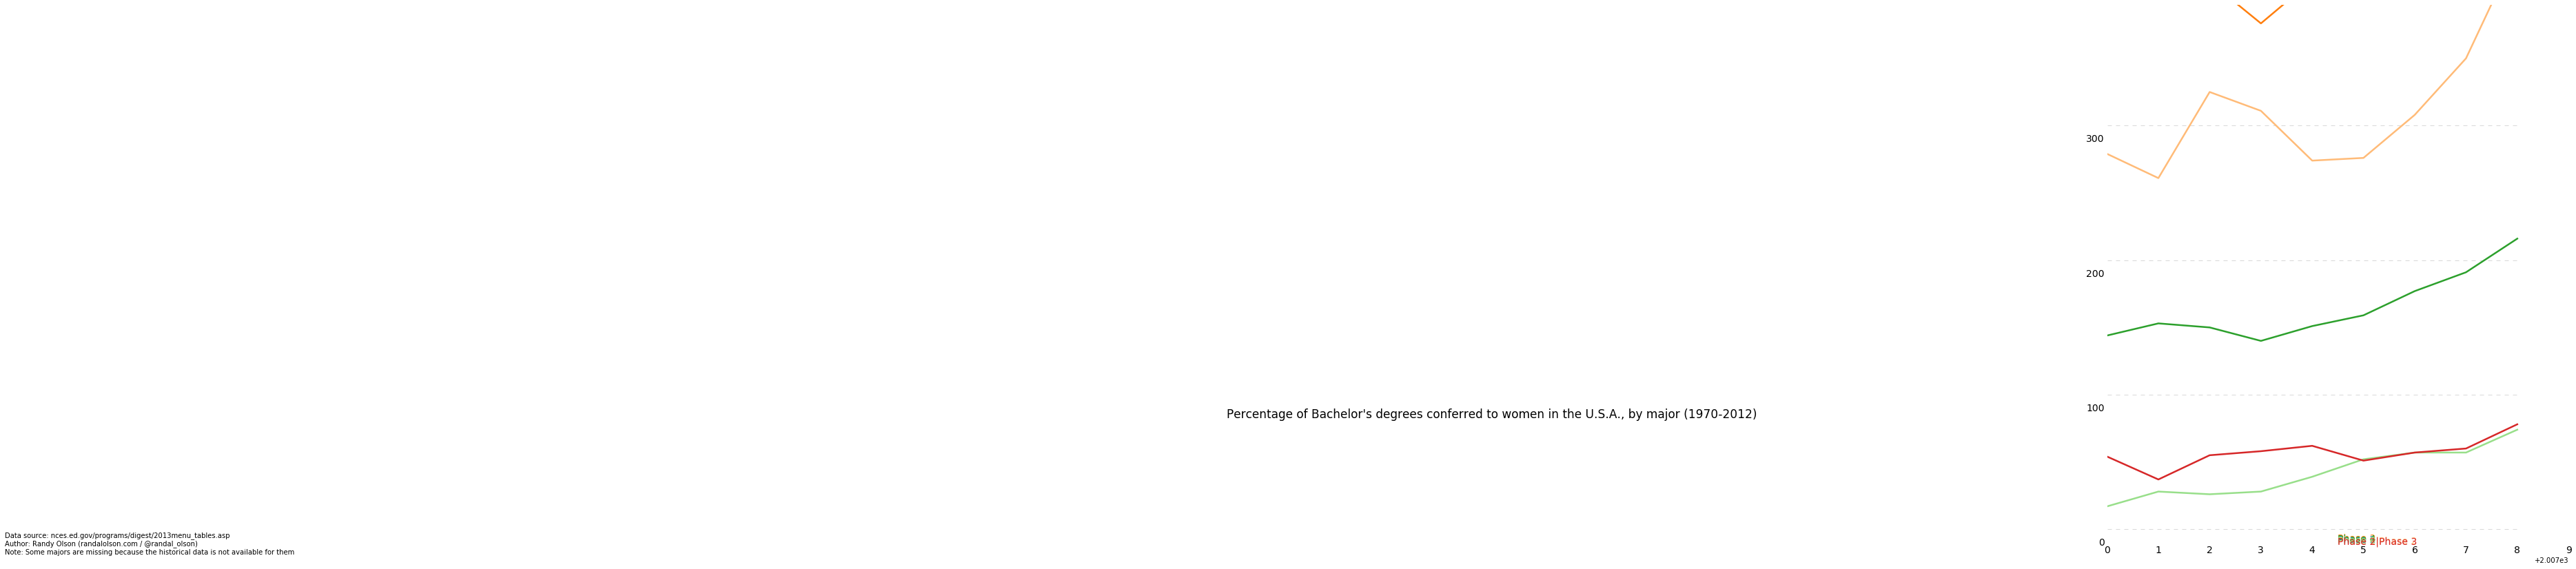

In [31]:
# You typically want your plot to be ~1.33x wider than tall. This plot is a rare    
# exception because of the number of lines being plotted on it.    
# Common sizes: (10, 7.5) and (12, 9)    
plt.figure(figsize=(12, 14))    
  
# Remove the plot frame lines. They are unnecessary chartjunk.    
ax = plt.subplot(111)    
ax.spines["top"].set_visible(False)    
ax.spines["bottom"].set_visible(False)    
ax.spines["right"].set_visible(False)    
ax.spines["left"].set_visible(False)    
  
# Ensure that the axis ticks only show up on the bottom and left of the plot.    
# Ticks on the right and top of the plot are generally unnecessary chartjunk.    
ax.get_xaxis().tick_bottom()    
ax.get_yaxis().tick_left()    
  
# Limit the range of the plot to only where the data is.    
# Avoid unnecessary whitespace.    
plt.ylim(0, 400)    
plt.xlim(2007, 2016)    
  
# Make sure your axis ticks are large enough to be easily read.    
# You don't want your viewers squinting to read your plot.    
plt.yticks(range(0, 400, 100), [str(x) for x in range(0, 400, 100)], fontsize=14)    
plt.xticks(fontsize=14)    
  
# Provide tick lines across the plot to help your viewers trace along    
# the axis ticks. Make sure that the lines are light and small so they    
# don't obscure the primary data lines.    
for y in range(10, 400, 100):    
    plt.plot(range(2007, 2016), [y] * len(range(2007, 2016)), "--", lw=0.5, color="black", alpha=0.3)    

# Remove the tick marks; they are unnecessary with the tick lines we just plotted.    
plt.tick_params(axis="both", which="both", bottom="off", top="off",    
                labelbottom="on", left="off", right="off", labelleft="on")    
  
# Now that the plot is prepared, it's time to actually plot the data!    
# Note that I plotted the majors in order of the highest % in the final year.    
# List of legend values
legend_vals = ['Phase 2', 'Phase 1', 'Phase 3', 'Phase 1|Phase 2', 'Phase 4', 'Phase 0', 'Phase 2|Phase 3']

for rank, column in enumerate(legend_vals):      
    # Plot each line separately with its own color, using the Tableau 20    
    # color set in order.    
    plt.plot(resampled.index.year,    
            resampled[column].values,    
            lw=2.5, color=tableau20[rank]) 
    # Add a text label to the right end of every line. Most of the code below  
    # is adding specific offsets y position because some labels overlapped.  
    y_pos = over_time_dummies[column].values[-1] - 0.5  
    if column == "Phase 2":  
        y_pos += 0.5  
    elif column == "Phase 1":  
        y_pos -= 0.5  
    elif column == "Phase 3":  
        y_pos += 0.75  
    elif column == "Phase 1|Phase2":  
        y_pos -= 0.25  
    elif column == "Phase 4":  
        y_pos += 1.25  
    elif column == "Phase 0":  
        y_pos += 0.25  
    elif column == "Phase 2|Phase 3":  
        y_pos -= 0.75   
        
    # Again, make sure that all labels are large enough to be easily read    
    # by the viewer.    
    plt.text(2011.5, y_pos, column, fontsize=14, color=tableau20[rank])    

# matplotlib's title() call centers the title on the plot, but not the graph,    
# so I used the text() call to customize where the title goes.    
  
# Make the title big enough so it spans the entire plot, but don't make it    
# so big that it requires two lines to show.    
  
# Note that if the title is descriptive enough, it is unnecessary to include    
# axis labels; they are self-evident, in this plot's case.    
plt.text(1995, 93, "Percentage of Bachelor's degrees conferred to women in the U.S.A."    
       ", by major (1970-2012)", fontsize=17, ha="center")    
  
# Always include your data source(s) and copyright notice! And for your    
# data sources, tell your viewers exactly where the data came from,    
# preferably with a direct link to the data. Just telling your viewers    
# that you used data from the "U.S. Census Bureau" is completely useless:    
# the U.S. Census Bureau provides all kinds of data, so how are your    
# viewers supposed to know which data set you used?    
plt.text(1966, -8, "Data source: nces.ed.gov/programs/digest/2013menu_tables.asp"    
       "\nAuthor: Randy Olson (randalolson.com / @randal_olson)"    
       "\nNote: Some majors are missing because the historical data "    
       "is not available for them", fontsize=10)    

### Clean Text Data
#### Sponsor/Collaborators column
Split cells with multiple sponsors, then create a new df with a column for each sponsor. Then join with original dataframe.

In [6]:
# split pipe delimited sponsor names into a list in each cell
s = trials['Sponsor/Collaborators'].str.split('|')

In [26]:
# The lead sponsor is the first one listed - generate new list with only lead sponsor
lead_sponsors = [row[0] for row in s]

In [28]:
# Turn lead_sponsors list to a pandas series
lead_sponsors_series = pd.Series(lead_sponsors)

In [35]:
# Get value counts
lead_sponsors_series.value_counts().sort_values(ascending=False)[:50]

M.D. Anderson Cancer Center                                 1387
National Cancer Institute (NCI)                             1263
Memorial Sloan Kettering Cancer Center                       854
Hoffmann-La Roche                                            605
Novartis Pharmaceuticals                                     478
Mayo Clinic                                                  403
AstraZeneca                                                  400
Pfizer                                                       320
Dana-Farber Cancer Institute                                 300
GlaxoSmithKline                                              299
Massachusetts General Hospital                               299
Washington University School of Medicine                     292
Eli Lilly and Company                                        289
Bristol-Myers Squibb                                         284
University Health Network, Toronto                           273
Sidney Kimmel Comprehensi

In [27]:
lead_sponsors[:100]

['National Cancer Institute (NCI)',
 'Celldex Therapeutics',
 'Rennes University Hospital',
 "Children's Oncology Group",
 'National Cancer Institute (NCI)',
 'M.D. Anderson Cancer Center',
 "Woman's Cancer Foundation",
 "Children's Oncology Group",
 'Gynecologic Oncology Group',
 'M.D. Anderson Cancer Center',
 'Janssen-Cilag Ltd.',
 'Sun Yat-sen University',
 'Clinical Directors Network',
 'European Organisation for Research and Treatment of Cancer - EORTC',
 'Medical University of Vienna',
 'Onyx Therapeutics, Inc.',
 'G. Hatzikosta General Hospital',
 'Association of Dermatological Prevention, Germany',
 'Beth Israel Deaconess Medical Center',
 'Memorial Sloan Kettering Cancer Center',
 'Case Comprehensive Cancer Center',
 "Children's Oncology Group",
 'M.D. Anderson Cancer Center',
 'PX Biosolutions',
 'Sun Yat-sen University',
 'Ohio State University Comprehensive Cancer Center',
 'Memorial Sloan Kettering Cancer Center',
 'Cancer Research UK',
 'M.D. Anderson Cancer Center',
 'M

In [7]:
# build out data structure to be converted to dataframe - essentially dummy columns for each sponsor
random_list = []
for row in s:
    sponsors_dict = {}
    for item in row:
        sponsors_dict[item] = 1
    random_list.append(sponsors_dict)

In [8]:
# create dataframe
sponsors_df = pd.DataFrame(random_list)

In [9]:
# over 10k columns... remove some? no, let's keep it as is for now
sponsors_df.shape

(43962, 10664)

In [10]:
sponsors_df.sum().sort_values(ascending=False)

National Cancer Institute (NCI)                                  5448.0
M.D. Anderson Cancer Center                                      1508.0
Memorial Sloan Kettering Cancer Center                            924.0
Novartis                                                          877.0
National Institutes of Health Clinical Center (CC)                694.0
Hoffmann-La Roche                                                 693.0
Novartis Pharmaceuticals                                          678.0
AstraZeneca                                                       610.0
Pfizer                                                            595.0
Merck Sharp & Dohme Corp.                                         581.0
Genentech, Inc.                                                   551.0
GlaxoSmithKline                                                   537.0
Celgene Corporation                                               511.0
Dana-Farber Cancer Institute                                    

In [7]:
# join sponsors_df with trials
# result = pd.concat([trials, sponsors_df], axis=1)

#### Funded Bys column
Split cells with multiple sponsors, then create a new df with a column for each sponsor. Then join with original dataframe.

In [8]:
# Split cells with multiple values
t = result['Funded Bys'].str.split('|')

In [9]:
# Build out data structure (list of dictionaries) that can be converted to a dataframe with a column for each funder
funded_by_list = []
for row in t:
    temp_dict = {}
    for z in row:
        temp_dict[z]=1
    funded_by_list.append(temp_dict)

In [10]:
# Convert to dataframe
funders_df = pd.DataFrame(funded_by_list)

In [11]:
# Join with result dataframe
second_result = pd.concat([result, funders_df], axis=1)

#### View funded bys over time

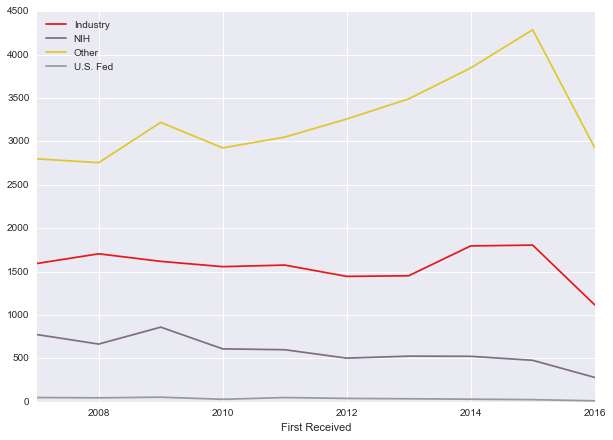

In [14]:
# Create new df object with columns for each of the funded by columns and index date first received
funded_bys = second_result.iloc[:, -4:].set_index(second_result['First Received'])

# Plot this data
funded_bys.resample('A').sum().plot(colormap='Set1', figsize=(10,7))

### Time between study start and completion; Time between study start and results recevied

In [93]:
# Create slice with columns of interest
duration = second_result[['NCT Number', 'Conditions', 'Gender', 'Age', 'Phases', 'Enrollment', 'Funded Bys', 'Study Types',
                         'First Received', 'Primary Completion Date']]

In [94]:
# Further slice to only include studies with primary completion date on or before present
duration = duration[duration['Primary Completion Date'] < '2016-08-27']

In [104]:
# Convert enrollment to int
duration.Enrollment = pd.to_numeric(duration.Enrollment, errors='coerce')

In [109]:
# bucket enrollment
bins = [0,50,100,200,300,500,1000,50000]
bucket_names = ['<50', '<100', '<200', '<300', '<500', '<1000', '>1000']

duration['enroll_buckets'] = pd.cut(duration.Enrollment, bins, labels=bucket_names)

In [111]:
# Group by enrollment
duration.groupby('enroll_buckets').mean()

,Enrollment,Duration_int
enroll_buckets,,
<50,24.511909,715.051921
<100,73.658497,717.167916
<200,146.407397,743.351335
<300,251.005255,698.091592
<500,399.026549,744.335479
<1000,709.487899,787.485963
>1000,4273.673121,614.277904


In [105]:
# Check for any nulls
duration.isnull().sum()

NCT Number                    0
Conditions                    0
Gender                        0
Age                           0
Phases                     9011
Enrollment                  134
Funded Bys                    0
Study Types                   0
First Received                0
Primary Completion Date       0
Duration                      0
Duration_int                  0
dtype: int64

In [96]:
duration['Duration'] = duration['Primary Completion Date'] - duration['First Received']

In [97]:
duration['Duration_int'] = duration.Duration.dt.days

In [98]:
duration.groupby('Phases').mean()

,Duration_int
Phases,
Phase 0,688.777778
Phase 1,785.526254
Phase 1|Phase 2,895.967260
Phase 2,842.394657
Phase 2|Phase 3,655.367500
Phase 3,774.839339
Phase 4,506.861282


In [99]:
duration.groupby('Funded Bys').mean().sort_values(by='Duration_int')

,Duration_int
Funded Bys,
Other|U.S. Fed|Industry|NIH,-534.000000
Other|Industry|U.S. Fed|NIH,323.000000
U.S. Fed|Industry|Other,407.000000
U.S. Fed|NIH,426.666667
Other|U.S. Fed|Industry,519.000000
Industry|Other,569.232099
Other,627.554184
Industry,654.822001
Other|U.S. Fed|NIH|Industry,678.000000


In [100]:
duration[duration.Duration_int < 0]

,NCT Number,Conditions,Gender,Age,Phases,Enrollment,Funded Bys,Study Types,First Received,Primary Completion Date,Duration,Duration_int
16,NCT01470586,Colorectal Cancer|Colon Rectal Resection|Oxida...,Both,"25 Years to 80 Years (Adult, Senior)",NaN,60,Other,Interventional,2011-11-05,2010-10-01,-400 days,-400
31,NCT01440855,Prostate Cancer|Breast Cancer|Colorectal Cance...,Both,"18 Years and older (Adult, Senior)",NaN,340,Other|NIH,Interventional,2011-09-22,2009-10-01,-721 days,-721
77,NCT01236053,"Pain, Neuropathic|Epilepsy|Renal Pelvis Cancer...",Both,"Child, Adult, Senior",NaN,2323608,Industry,Observational,2010-10-14,2010-09-01,-43 days,-43
85,NCT00656604,Breast Cancer,Female,"18 Years and older (Adult, Senior)",NaN,30,Other|NIH,Interventional,2008-04-10,2005-10-01,-922 days,-922
97,NCT01335152,Breast Cancer,Female,"18 Years and older (Adult, Senior)",Phase 1|Phase 2,100,Industry|NIH,Interventional,2011-04-12,2011-04-01,-11 days,-11
176,NCT00483639,Anxiety Disorder|Head and Neck Cancer|Lung Cancer,Both,"21 Years to 70 Years (Adult, Senior)",NaN,100,Other|NIH,Observational,2007-06-06,2006-03-01,-462 days,-462
224,NCT00923481,Head and Neck Neoplasms|Pheochromocytoma|Color...,Both,"18 Years and older (Adult, Senior)",Phase 2,37,NIH,Interventional,2009-06-17,2009-04-01,-77 days,-77
234,NCT00653250,Lung Cancer,Both,"Child, Adult, Senior",NaN,22,Other|NIH,Interventional,2008-04-03,2006-03-01,-764 days,-764
264,NCT00433394,"Unspecified Childhood Solid Tumor, Protocol Sp...",Both,"up to 20 Years (Child, Adult)",NaN,2242,Other|NIH,Interventional,2007-02-09,2007-01-01,-39 days,-39
266,NCT01415375,Prostate Cancer Screening Decision,Male,"45 Years to 70 Years (Adult, Senior)",Phase 2|Phase 3,490,Other,Interventional,2011-08-10,2007-07-01,-1501 days,-1501


In [32]:
# check nulls of First Received and Primary Completion Date
print second_result['First Received'].isnull().sum()
print second_result['Primary Completion Date'].isnull().sum()

0
1378


In [31]:
second_result['Primary Completion Date'] - second_result['First Received']

0        1880 days
1        1511 days
2        1766 days
3        3889 days
4         411 days
5        1053 days
6        1303 days
7        1980 days
8        2002 days
9        2246 days
10        405 days
11       1586 days
12       1141 days
13       1608 days
14       1424 days
15       2574 days
16       -400 days
17        719 days
18       2421 days
19       3325 days
20        389 days
21       2848 days
22        885 days
23        178 days
24       1129 days
25       1862 days
26       1815 days
27             NaT
28       3088 days
29       3773 days
           ...    
43932   -1699 days
43933     327 days
43934     978 days
43935     321 days
43936    -199 days
43937     420 days
43938     251 days
43939     565 days
43940     757 days
43941     221 days
43942          NaT
43943     228 days
43944          NaT
43945     572 days
43946     579 days
43947     595 days
43948          NaT
43949    3644 days
43950    1442 days
43951    1010 days
43952      35 days
43953     45

In [27]:
second_result.iloc[1,:]

Rank                                                                                                    2
NCT Number                                                                                    NCT01460134
Title                                                   A Study of CDX-1127 (Varlilumab) in Patients W...
Recruitment                                                                        Active, not recruiting
Study Results                                                                        No Results Available
Conditions                                              CD27 Expressing B-cell Malignancies, (for Exam...
Interventions                                                Drug: CDX-1127|Drug: CDX-1127|Drug: CDX-1127
Sponsor/Collaborators                                                                Celldex Therapeutics
Gender                                                                                               Both
Age                                           

In [25]:
second_result.Recruitment.value_counts()

Recruiting                   14915
Completed                    14504
Active, not recruiting        6439
Terminated                    3225
Not yet recruiting            2654
Withdrawn                     1180
Enrolling by invitation        579
Suspended                      314
Available                       71
No longer available             55
Approved for marketing          20
Temporarily not available        6
Name: Recruitment, dtype: int64

In [4]:
trials.columns

Index([u'Rank', u'NCT Number', u'Title', u'Recruitment', u'Study Results',
       u'Conditions', u'Interventions', u'Sponsor/Collaborators', u'Gender',
       u'Age', u'Phases', u'Enrollment', u'Funded Bys', u'Study Types',
       u'Study Designs', u'Other IDs', u'First Received', u'Start Date',
       u'Completion Date', u'Last Updated', u'Last Verified',
       u'Results First Received', u'Acronym', u'Primary Completion Date',
       u'Outcome Measures', u'URL'],
      dtype='object')

In [5]:
# some value counts
print trials.Recruitment.value_counts(), '\n'
print trials['Study Results'].value_counts(), '\n'
print trials.Gender.value_counts(), '\n'
print trials.Phases.value_counts(), '\n'
print trials['Funded Bys'].value_counts(), '\n'
print trials['Study Types'].value_counts(), '\n'
print trials['Study Results'].value_counts()

Recruiting                   14915
Completed                    14504
Active, not recruiting        6439
Terminated                    3225
Not yet recruiting            2654
Withdrawn                     1180
Enrolling by invitation        579
Suspended                      314
Available                       71
No longer available             55
Approved for marketing          20
Temporarily not available        6
Name: Recruitment, dtype: int64 

No Results Available    40069
Has Results              3893
Name: Study Results, dtype: int64 

Both      34809
Female     6567
Male       2543
null         43
Name: Gender, dtype: int64 

Phase 2            11633
Phase 1             6632
Phase 3             4110
Phase 1|Phase 2     3183
Phase 4             1708
Phase 2|Phase 3      661
Phase 0              533
Name: Phases, dtype: int64 

Other                          22592
Industry                        9787
Other|Industry                  4767
Other|NIH                       3892
NIH  

In [6]:
# how many unique conditions, interventions, and sponsors are listed?
print len(trials.Conditions.unique())
print len(trials.Interventions.unique())
print len(trials['Sponsor/Collaborators'].unique())
print len(trials.Age.unique())

18567
34003
15139
1252


In [8]:
# View nulls
pd.isnull(trials).sum()

Rank                           0
NCT Number                     0
Title                          0
Recruitment                    0
Study Results                  0
Conditions                     0
Interventions               4253
Sponsor/Collaborators          0
Gender                         0
Age                            0
Phases                     15502
Enrollment                     0
Funded Bys                     0
Study Types                    0
Study Designs                518
Other IDs                      8
First Received                 0
Start Date                     0
Completion Date                0
Last Updated                   0
Last Verified                  0
Results First Received         0
Acronym                        0
Primary Completion Date        0
Outcome Measures            1101
URL                            0
dtype: int64

In [12]:
# trials.set_index(trials['First Received'], inplace=True)

# plot trials over time - wonder what caused massive btwn 2012 and 2015?
# trials['NCT Number'].resample('A').count().plot()

# plot the count of trials per year that have results over time
# trials[trials['Study Results'] == 'Has Results']['NCT Number'].resample('A').count().plot()